# Probabilistic Machine Learning
#### Machine Learning in Science, University of Tübingen, Summer Semester 2022
## Exercise 11

Authors: Janne Lappalainen, Jaivardhan Kapoor

**hand in before 15.07.2022, 12:00 p.m. (noon)**

---
In the lecture you learned about normalizing flows, a series of bijective transformations on random variables to learn probability densities. In this programming exercise, you will explore how to build and train normalizing flows in `Pytorch`. For this assigmnent, you will use `Pyro`, a popular (and powerful) probabilistic programming library based on `Pytorch`.

## Outline
1) Creating composable and invertible transformations in `Pyro`.

2) Approximating complex univariate distributions using learnable bijections in `Pyro`.

3) Approximating multivariate distributions using normalizing flows -- analysing the importance of coupling flows as opposed to merely learning marginals. 

### References:

[1] Kevin P Murphy. "Probabilistic Machine Learning: Advanced Topics". Chapter 23. https://probml.github.io/pml-book/book2.html

[2] https://pyro.ai/examples/normalizing_flows_i.html

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats.distributions import beta

np.random.seed(42)

import torch
import matplotlib.pyplot as plt
import os
import seaborn as sns

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
smoke_test = ('CI' in os.environ)

# to ignore seaborn deprecation warnings
import warnings
warnings.filterwarnings("ignore")


# importing pyro modules 
import pyro
import pyro.distributions as dist
import pyro.distributions.transforms as T

# Normalizing flows
## Convert a simple probability distribution to a complex probability distribution

Consider a random variable $\mathbf{u} \in \mathbb{R}^d$ from a simple base distribution $p_{\mathbf{u}}(\mathbf{u})$, e.g. standard normal -- so that we can sample it easily, $\mathbf{u} \sim \mathcal{N}(0, \mathbb{1})$. A normalizing flow is a bijective (in fact diffeomorphic, i.e. bijective and differentiable) transformation that transforms $\mathbf{u}$ into  $\mathbf{x}$ with a more complex distribution over it.

$$\mathbf{x} = f(\mathbf{u}) \qquad \text{with }\,\mathbf{x} \in \mathbb{R}^d,\,\mathbf{u} \sim p_{\mathbf{u}}(\mathbf{u})\text{.}$$

To sample from the distribution over $\mathbf{x}$, denoted by $p_\mathbf{x}(\mathbf{x})$, we simply sample from $p_{\mathbf{u}}(\mathbf{u})$ and then compute $\mathbf{x}=f(\mathbf{u})$.
Because $f$ is bijective, we can compute the density $p(\mathbf{x})$ using the change-of-variables formula for random variables and the inverse function theorem for Jacobian matrices:

$$p_\mathbf{x}(\mathbf{x}) = p_\mathbf{u}(f^{-1}(\mathbf{x}))|\text{det}\,\mathbf{J}_{f^{-1}}(\mathbf{y})| = p_\mathbf{u}(\mathbf{u})|\text{det}\,\mathbf{J}_f(\mathbf{u})|^{-1}\text{.}$$

$\mathbf{J}_f$ with $J_{f,ij} = \frac{\partial f_i}{\partial \mathbf{u}_j}$ is the Jacobian of $f$ evaluated at $\mathbf{u}$. We can take the logarithm of the above equation:

$$\log p_\mathbf{x}(\mathbf{x}) = \log p_\mathbf{u}(\mathbf{u}) - \log|\text{det}\,\mathbf{J}_f(\mathbf{u})|$$

to gain an intuitive understanding: the density of $\mathbf{x}$ is equal to the density at the corresponding point $\mathbf{u}$ up to a term that corrects for the _warp_ in the volume caused by $f$.

Furthermore, we can compose bijective transformations to produce even more expressive transformations. With $N$ transformations $f_1, \ldots, f_N$, the initial random vector gets transformed by composing these transformations:

\begin{align*}
\mathbf{x}^{(0)} &= \mathbf{u}\\
\mathbf{x}^{(1)} &= f_1(\mathbf{x}^{(0)})\\
& \vdots \\
\mathbf{x} = \mathbf{x}^{(N)} &= f_N(\mathbf{x}^{(N-1)})\\
\end{align*}

the density of the final transformation can be written as

$$\log p_\mathbf{x}(\mathbf{x}) = \log p_\mathbf{u}( (f_n\circ ...\circ f_1)^{-1} (\mathbf{x})) - \sum_{n=1}^N\log|\text{det}\,\mathbf{J}_{f_i}(\mathbf{x}^{(i-1)})|,$$

as the composition of invertible functions is also invertible, with the resulting Jacobian being the product of the Jacobians of all transformations. The transformation $f_n\circ ...\circ f_1$ desribes a succesive warp of the volume in the space of $\mathbf{u}$. Such a family of diffeomorpishms is called "flow" in mathematics -- with the base density $\log p_\mathbf{u}$ usually being a normal distribution, the term _normalizing flows_ was coined. 

## Implementing a composition of simple invertible transformations in Pyro

For this programming exercise, please keep the `Pyro` [documentation](https://docs.pyro.ai/en/stable/) open and refer to respective sections for transformations, distributions, learning methods etc.

1. The [log-normal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution) is a continuous probability distribution frequenty used in sciences and economics. The logarithm of a log-normally distributed variable $x$ is normally distributed, that is, $\log(x)\sim \mathcal{N}(\mu, \sigma^2)$.\
\
Your task is to generate samples of a log-normally distributed random variable. Starting from a normally-distributed variable, compose _affine_ and _non-linear_ transformations to create a log-normal distribution with $\mu=3, \sigma=0.5$. Plot samples and [KDE plot](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) for both the original normal distribution and the lognormal distribution.\
\
Use `pyro.distributions` and `pyro.distributions.transforms` in your implementation.

In [2]:
# Create a distribution by composing transforms and applying them to a base distribution
normal = dist.Normal(0, 1)
affine_transform = T.AffineTransform(loc=3, scale=0.5)
exp_transform = T.ExpTransform()
log_normal = dist.TransformedDistribution(normal, [affine_transform, exp_transform])

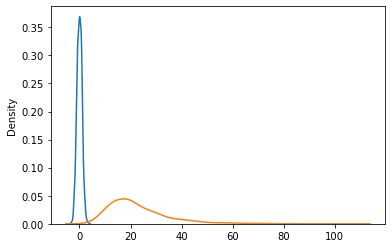

In [3]:
# Plot the KDE plot of the base distribution and transformed distribution here.
sns.kdeplot(normal((1000,)))
sns.kdeplot(log_normal((1000,)))
pass

## Implementing learnable invertible transformations (with the Pytorch backend)

2. In this section you will create a learnable normalizing flow and infer its parameters, given a dataset. Then you will plot samples from the flow and compare with the dataset.

(a) Generate the dataset by sampling from the previous lognormal distribution with $\mu=3, \sigma=0.5$.

In [4]:
n_samples = 1000

In [5]:
# Generate dataset from previously created lognormal distribution object
xs = log_normal((n_samples, ))

[Neural Spline Flows](https://arxiv.org/abs/1906.04032) are a highly flexible class of learnable bijective transformations. _Monotonic rational splines_ are flexible functions that are of the form 

\begin{align*}
s(u) = \begin{cases}
u & u \leq -B;\\
\frac{g_i(u)}{h_i(u)} & u \in [b_i, b_{i+1}]~\forall i \in \{1, \ldots, K\};\\
u & u \geq B;
 & \end{cases}
\end{align*}
The spline is made up of segments, with each segment represented by a rational function ($g,h$ are both linear or quadratic in $u$). At the knots $b_i$, i.e., the boundaries of the segments, a continuity constraint is placed on the values and derivatives:

\begin{align*}
\frac{g_{i-1}(b_{i})}{h_{i-1}(b_{i})} &= \frac{g_{i}(b_{i})}{h_{i}(b_{i})}, \text{and}\\
\frac{d}{du}\left(\frac{g_{i-1}(b_{i})}{h_{i-1}(b_{i})}\right) &= \frac{d}{du}\left(\frac{g_{i}(b_{i})}{h_{i}(b_{i})}\right)
\end{align*}

![Spline](spline.jpg "Example of a monotonic rational spline") ![DetSpline](splinedet.jpg "Derivative of the Spline")

Furthermore, the parameters of $g_i, h_i$ are also constructed in a way that the spline $s(u)$ is monotonically increasing in $u$, and $s(u) = u$ at $-B, B$. This makes $s(u)$ a flexible bijection -- by learning the parameters of $g_i$'s and $h_i$'s, $p_u(u)$ can be transformed into the desired $p_x(x)$.

<br><br>

(b) Scale the dataset you just created to zero mean and unit variance. Fit a learnable rational linear spline with 7 segments to the dataset. Use the loss based on Maximum Likelihood Estimation using the log-probability method of the [`Spline`](https://docs.pyro.ai/en/stable/distributions.html#pyro.distributions.transforms.Spline) object, and optimize it using `SGD`/`Adam` optimizer from [`Pyro.optim.pytorch_optimizers`](https://docs.pyro.ai/en/stable/optimization.html#pyro.optim.pytorch_optimizers).\
\
  After learning the paramters of the `Spline` object, generate new samples from it and compare the learned distribution with the original lognormal distribution. (Make sure to apply the inverse scaling you applied to the dataset in the first place for training.)\
\
  How does the learned distribution change as you increase the number of segments in the spline? 

In [6]:
# scale your data, so that it falls roughly into the domain/range of the Spline object

normalizer = StandardScaler().fit(xs.reshape(-1,1))
#print(xs.shape)
xs_norm = normalizer.transform(xs.reshape(-1,1))

In [7]:
# Create your distribution with learnable transformation parameters

# create base distribution
base_dist = dist.Normal(loc=0, scale=1)

# create spline transform
# Tip: use the visualize_spline() function at the bottom of this notebook to develop intuition for the spline transformation.
spline_transform = T.Spline(1, count_bins=100, order='linear')
#visualize_spline(spline_transform)

# create transformed distribution
flow_dist = dist.TransformedDistribution(base_dist, [spline_transform])

In [8]:
# Implement the training loop after initializing the optimizer and use the loss function provided by `log_prob` method of the TransformedDistribution object. Learn the parameters by optimizing the loss.

dataset = torch.tensor(xs_norm, dtype=torch.float)
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=1e-2)
for step in range(1000):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()

    if step % 200 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))


step: 0, loss: 3.1668686866760254
step: 200, loss: 1.334047794342041
step: 400, loss: 1.2164864540100098
step: 600, loss: 1.1930038928985596
step: 800, loss: 1.1805628538131714


In [9]:
# Plot the base distribution, distribution of the original dataset, and samples from the learned distribution.

#plot samples
#num_samples = 15
#samples = np.concatenate([flow_dist.sample((1,)).numpy() for _ in range(num_samples)])
#samples = normalizer.inverse_transform(samples.reshape(-1, 1)).squeeze()
#plt.scatter(samples, np.zeros(len(samples)), marker='+')

#plot_xs = torch.linspace(1e-5,100, steps=1000)

# plot learned PDF
#plot_xs_norm = normalizer.transform(plot_xs.reshape(-1, 1))
#with torch.no_grad():
#    flow_density = [flow_dist.log_prob(torch.tensor(x)) for x in plot_xs.reshape(-1, 1)]
#    flow_density = np.exp(np.concatenate(flow_density))
#    plt.plot(plot_xs, flow_density)
    
# plot original PDF
#log_normal_density = [log_normal.log_prob(torch.tensor(x)).item() for x in plot_xs]
#log_normal_density = np.exp(np.array(log_normal_density))
#plt.plot(plot_xs, log_normal_density)
#pass

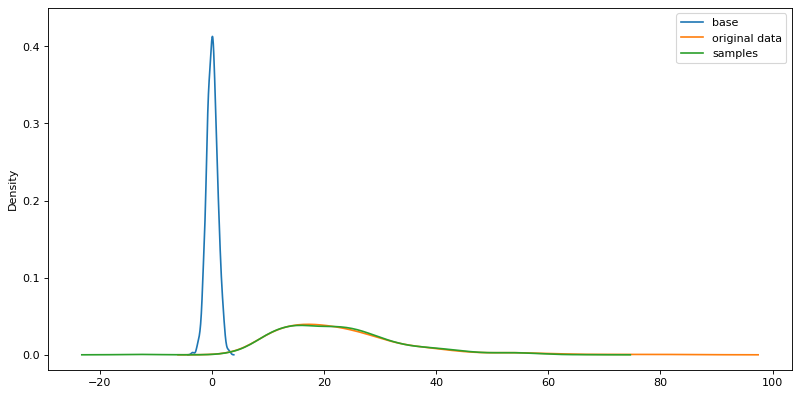

In [9]:
# Plot the base distribution, distribution of the original dataset, and samples from the learned distribution.

plt.figure(figsize=(12, 6), dpi=80)

# base dist
sns.kdeplot(normal((1000,)), label='base')

# original dataset
sns.kdeplot(xs, label='original data')

# samples
num_samples = 1000
samples = np.concatenate([flow_dist.sample((1,)).numpy() for _ in range(num_samples)])
samples = normalizer.inverse_transform(samples.reshape(-1, 1)).squeeze()
#plt.scatter(samples, np.zeros(len(samples)), marker='+', label='samples')
sns.kdeplot(samples, label='samples')

plt.gca().set_ylim([-0.02, 0.45])
plt.legend()
pass

As we increase the number of bins, the spline can approximate the data distribution more and more accurately.

(c) To gauge the expressivity of the rational monotonic splines, we will attempt to approximate a multimodal univariate distribution.

In [10]:
def complex_univariate_random_variable(n_samples):
    # cheap way to create a more complicated
    # toy univariate random variable    
    X, y = datasets.make_circles(n_samples, noise=0.05, factor=0.5)
    X = StandardScaler().fit_transform(X)
    return X[:, 0].reshape(-1, 1)

Text(0.5, 1.0, 'Complex univariate random variable')

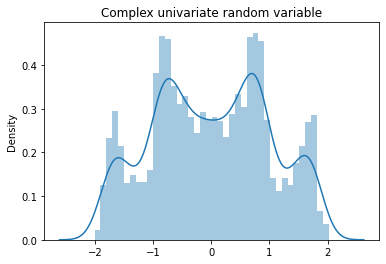

In [11]:
n_samples = 3000
x = complex_univariate_random_variable(n_samples)
sns.distplot(x, hist=True, kde=True, bins=40)
plt.title("Complex univariate random variable")

  (i) Create a simple spline with few (2-5) segments, and approximate the above distribution. How good is the approximation compared to a more expressive spline with 6+ segments?\
\
  (ii) Now create multiple splines with few (2-5) segments, and compose them together to make a more powerful approximation. How well does it learn to approximate this multimodal density?

In [12]:
# Create the learnable TransformedDistribution object.

base_dist = dist.Normal(loc=0, scale=1)

spline_3_0 = T.Spline(1, count_bins=3, order='linear')
spline_9 = T.Spline(1, count_bins=9, order='linear')
spline_3_1 = T.Spline(1, count_bins=3, order='linear')
spline_3_2 = T.Spline(1, count_bins=3, order='linear')
spline_3_3 = T.Spline(1, count_bins=3, order='linear')
#spline_3_4 = T.Spline(1, count_bins=3, order='linear')

# create transformed distribution
flow_dist_simple = dist.TransformedDistribution(base_dist, [spline_3_0])
flow_dist_morebins = dist.TransformedDistribution(base_dist, [spline_9])
flow_dist_composed = dist.TransformedDistribution(base_dist, [spline_3_1, spline_3_2, spline_3_3])

In [13]:
# Train the parameters of the flow. Note that you may have to tweak learning hyperparameters such as number of trainig steps and learning rate.
dataset = torch.tensor(x, dtype=torch.float)
optimizer1 = torch.optim.Adam(spline_3_0.parameters(), lr=1e-2)
optimizer2 = torch.optim.Adam(spline_9.parameters(), lr=1e-2)
optimizer3 = torch.optim.Adam(list(spline_3_1.parameters())+list(spline_3_2.parameters())+list(spline_3_3.parameters()), lr=1e-2)
for step in range(1000):
    optimizer1.zero_grad()
    optimizer2.zero_grad()
    optimizer3.zero_grad()
    loss1 = -flow_dist_simple.log_prob(dataset).mean()
    loss2 = -flow_dist_morebins.log_prob(dataset).mean()
    loss3 = -flow_dist_composed.log_prob(dataset).mean()
    loss1.backward()
    loss2.backward()
    loss3.backward()
    optimizer1.step()
    optimizer2.step()
    optimizer3.step()
    flow_dist_simple.clear_cache()
    flow_dist_morebins.clear_cache()
    flow_dist_composed.clear_cache()

    if step % 200 == 0:
        print('step: {}, loss1: {}'.format(step, loss1.item()))
        print('step: {}, loss2: {}'.format(step, loss2.item()))
        print('step: {}, loss3: {}'.format(step, loss3.item()))


step: 0, loss1: 4.863643646240234
step: 0, loss2: 2.6790809631347656
step: 0, loss3: 2.312852144241333
step: 200, loss1: 1.3936539888381958
step: 200, loss2: 1.332515835762024
step: 200, loss3: 1.3381050825119019
step: 400, loss1: 1.3873710632324219
step: 400, loss2: 1.2852152585983276
step: 400, loss3: 1.3271422386169434
step: 600, loss1: 1.3855289220809937
step: 600, loss2: 1.2754141092300415
step: 600, loss3: 1.3248077630996704
step: 800, loss1: 1.384584903717041
step: 800, loss2: 1.2738865613937378
step: 800, loss3: 1.32262122631073


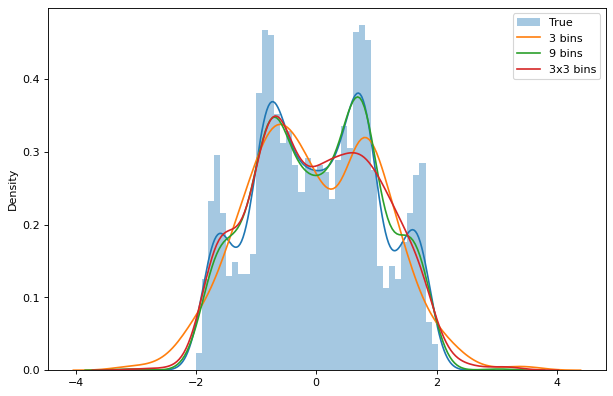

In [14]:
# Plot samples from the learned flow along with the dataset, and compare the quality of the approximation.
num_samples=1000

plt.figure(figsize=(9, 6), dpi=80)
sns.distplot(x, hist=True, kde=True, bins=40, label='True')
samples_1 = np.concatenate([flow_dist_simple.sample((1,)).numpy() for _ in range(num_samples)])
sns.kdeplot(samples_1, label='3 bins')
samples_2 = np.concatenate([flow_dist_morebins.sample((1,)).numpy() for _ in range(num_samples)])
sns.kdeplot(samples_2, label='9 bins')
samples_3 = np.concatenate([flow_dist_composed.sample((1,)).numpy() for _ in range(num_samples)])
sns.kdeplot(samples_3, label='3x3 bins')
plt.legend()
pass

Write your observations here on the number of segments used vs the number of splines composed together.

Here, the 9 bin model works best, while the 3x3 bin model is inaccurate at the second mode.

## Approximating distributions for multivariate data

The monotonic rational splines used in the previous sections are univariate functions. To approximate multivariate densities, we need to create expressive _multivariate bijections_.

In the lecture on normalizing flows, we saw how _coupling transformations_ can be used to convert univariate pointwise bijections into more powerful multivariate bijections.

In this section, you will play around with approximating a density in 2 dimensions. The dataset that will be used is a superposition of 2 hearts, as seen below.

You will first approximate the density by approximating marginals using a spline for each marginal. Then you will use [spline coupling](https://docs.pyro.ai/en/stable/distributions.html#splinecoupling) transforms ([1], Section 2.1) to approximate the 2D distribution.

[1] [Neural Spline Flows (NeurIPS 2019)](https://arxiv.org/pdf/1906.04032.pdf)

In [15]:
def make_hearts(
    n_samples=100, *, shuffle=True, noise=None, random_state=None, factor=0.8, offset=None,
    scale=True
):
    """Make a large heart containing a smaller heart in 2d.

    A simple toy dataset to visualize clustering and classification
    algorithms.

    Read more in the :ref:`User Guide <sample_generators>`.

    Parameters
    ----------
    n_samples : int or tuple of shape (2,), dtype=int, default=100
        If int, it is the total number of points generated.
        For odd numbers, the inner heart will have one point more than the
        outer heart.
        If two-element tuple, number of points in outer heart and inner
        heart.

        .. versionchanged:: 0.23
           Added two-element tuple.

    shuffle : bool, default=True
        Whether to shuffle the samples.

    noise : float, default=None
        Standard deviation of Gaussian noise added to the data.

    random_state : int, RandomState instance or None, default=None
        Determines random number generation for dataset shuffling and noise.
        Pass an int for reproducible output across multiple function calls.
        See :term:`Glossary <random_state>`.

    factor : float, default=.8
        Scale factor between inner and outer heart in the range `(0, 1)`.

    Returns
    -------
    X : ndarray of shape (n_samples, 2)
        The generated samples.

    y : ndarray of shape (n_samples,)
        The integer labels (0 or 1) for class membership of each sample.
    """
    
    import numbers
    from sklearn.utils import shuffle as util_shuffle
    from sklearn.utils import check_random_state

    if factor >= 1 or factor < 0:
        raise ValueError("'factor' has to be between 0 and 1.")

    if isinstance(n_samples, numbers.Integral):
        n_samples_out = n_samples // 2
        n_samples_in = n_samples - n_samples_out
    else:
        try:
            n_samples_out, n_samples_in = n_samples
        except ValueError as e:
            raise ValueError(
                "`n_samples` can be either an int or a two-element tuple."
            ) from e

    generator = check_random_state(random_state)
    # so as not to have the first point = last point, we set endpoint=False
    linspace_out = np.linspace(0, 2 * np.pi, n_samples_out, endpoint=False)
    linspace_in = np.linspace(0, 2 * np.pi, n_samples_in, endpoint=False)
    
    def heart(t):
        return (16 * np.sin(t) ** 3,
                13 * np.cos(t) - 5 * np.cos(2 * t) - 2 * np.cos(3 * t) - np.cos(4 * t))
    
    outer_heart_x, outer_heart_y = heart(linspace_in)
    inner_heart_x, inner_heart_y = heart(linspace_out)
    if offset is not None:
        inner_heart_x += offset[0]
        inner_heart_y += offset[1]
    inner_heart_x *= factor
    inner_heart_y *= factor

    X = np.vstack(
        [np.append(outer_heart_x, inner_heart_x), np.append(outer_heart_y, inner_heart_y)]
    ).T
    y = np.hstack(
        [np.zeros(n_samples_out, dtype=np.intp), np.ones(n_samples_in, dtype=np.intp)]
    )
    if shuffle:
        X, y = util_shuffle(X, y, random_state=generator)

    if noise is not None:
        X += generator.normal(scale=noise, size=X.shape)
        
    if scale:
        X = StandardScaler().fit_transform(X)

    return X, y

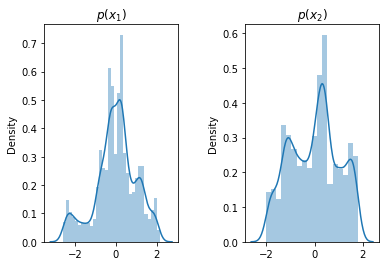

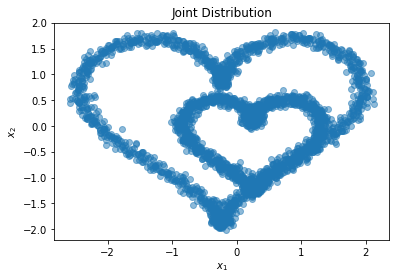

In [16]:
# creating the hearts dataset and visualizing marginals and joint density


X, _ = make_hearts(n_samples, factor=0.5, noise=0.5, offset=[7, -7])

plt.subplot(1, 2, 1)
sns.distplot(X[:,0], label='data')
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(X[:,1], label='data')
plt.title(r'$p(x_2)$')
plt.subplots_adjust(wspace=0.5)
plt.show()


plt.title(r'Joint Distribution')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], label='data', alpha=0.5)
plt.show()

4. Use a 2D `Spline` to learn the multivariate transformation. Plot the marginals and plot the joint distribution of the learned distribution, and compare against the data.

In [26]:
# Create the learnable distribution with 2D Spline

base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
spline_transform = T.Spline(2, count_bins=16)
flow_dist = dist.TransformedDistribution(base_dist, [spline_transform])


In [27]:
# Learn the parameters of the Spline as in the previous sections

steps = 1000
dataset = torch.tensor(X, dtype=torch.float)
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=1e-2)
for step in range(steps):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()

    if step % 200 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 2.7059671878814697
step: 200, loss: 1.2876808643341064
step: 400, loss: 1.2581790685653687
step: 600, loss: 1.2519851922988892
step: 800, loss: 1.2475264072418213


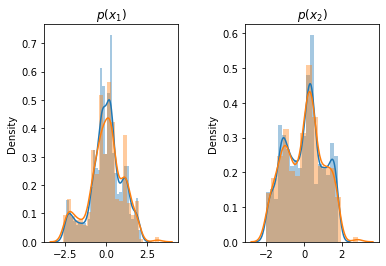

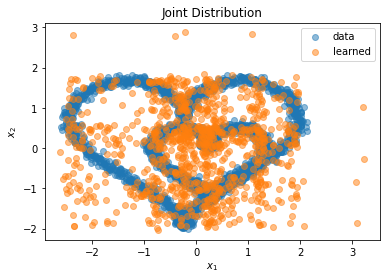

In [28]:
# Plot the marginals and joint density of the learned distribution and compare against the true data distribution.

X_flow = flow_dist.sample(torch.Size([1000,])).detach().numpy()

# true dist
plt.subplot(1, 2, 1)
sns.distplot(X[:,0], label='data')
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(X[:,1], label='data')
plt.title(r'$p(x_2)$')
plt.subplots_adjust(wspace=0.5)

#learned dist
plt.subplot(1, 2, 1)
sns.distplot(X_flow[:,0], label='learned')
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(X_flow[:,1], label='learned')
plt.title(r'$p(x_2)$')
plt.subplots_adjust(wspace=0.5)
plt.show()


# JOINT------------
plt.title(r'Joint Distribution')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], label='data', alpha=0.5)
plt.scatter(X_flow[:,0], X_flow[:,1], label='learned', alpha=0.5)
plt.legend()
plt.show()



Question: How well does the learned distribution approximate the marginals? How well does it approximate the joint density? Justify your observations.

Answer: The marginals are modeled rather well (although they don't match exactly). However, the model cannot capture the dependencies between the dimensions, because the spline transform transforms each dimension separately without modeling dependencies/covariances. This results in very inaccurate model of the joint.

5. Use [`SplineCoupling`](https://docs.pyro.ai/en/stable/distributions.html#splinecoupling) to learn the complex multivariate transformation. Plot and inspect the marginals and joint density.


In [23]:
# Create learnable distribution

base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
spline_transform = T.spline_coupling(2, count_bins=16)
flow_dist = dist.TransformedDistribution(base_dist, [spline_transform])


In [24]:
# Learn the parameters of the coupling splie flow

steps = 5000
dataset = torch.tensor(X, dtype=torch.float)
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=5e-3)
for step in range(steps+1):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()

    if step % 500 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))


step: 0, loss: 4.728880882263184
step: 500, loss: 1.583717942237854
step: 1000, loss: 1.4758150577545166
step: 1500, loss: 1.4080393314361572
step: 2000, loss: 1.414441704750061
step: 2500, loss: 1.4222077131271362
step: 3000, loss: 1.386366844177246
step: 3500, loss: 1.3798266649246216
step: 4000, loss: 1.3807291984558105
step: 4500, loss: 1.4833996295928955
step: 5000, loss: 1.3536789417266846


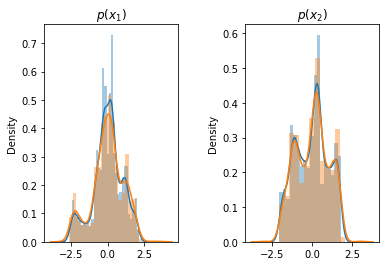

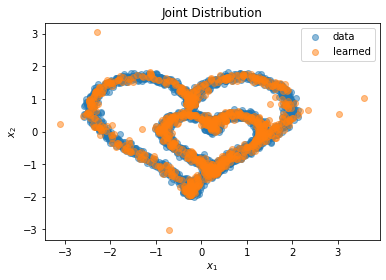

In [25]:
# Plot the marginals and joint of the learned distribution against the true data distribution.

X_flow = flow_dist.sample(torch.Size([1000,])).detach().numpy()

# true dist
plt.subplot(1, 2, 1)
sns.distplot(X[:,0], label='data')
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(X[:,1], label='data')
plt.title(r'$p(x_2)$')
plt.subplots_adjust(wspace=0.5)

#learned dist
plt.subplot(1, 2, 1)
sns.distplot(X_flow[:,0], label='learned')
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(X_flow[:,1], label='learned')
plt.title(r'$p(x_2)$')
plt.subplots_adjust(wspace=0.5)
plt.show()


# JOINT------------
plt.title(r'Joint Distribution')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], label='data', alpha=0.5)
plt.scatter(X_flow[:,0], X_flow[:,1], label='learned', alpha=0.5)
plt.legend()
plt.show()


Question: What is the quality of the marginal and joint densities with the coupling transformation?

Answer: Both are very accurate. The spline_coupling transform models dependencies between dimensions by coupling multiple splines, which divide the input into two parts and parameterize the bijection used for the lower part with the upper part (and repeating this multiple times). Thus, the correlations in the joint distribution are modeled very well, recreating the original distribution more or less exactly (up to some outliers).

## Miscellaneous helper code

In [ ]:
def visualize_spline(spline_: T.Spline, dim=0):
    '''
    Helper function for plotting the spline function with its derivatives.
    Args:
        spline_: `Spline` object
        dim: dimension of the spline to visualize, for multivariate spline
    '''
    with torch.no_grad():
        D = spline_.input_dim
        B = spline.bound
        u = torch.from_numpy(np.linspace(-1.2*B, 1.2*B, 1000))
        x, logdet = spline_.spline_op(u.unsqueeze(1).repeat(1, D))
        print(x.shape, logdet.shape)
        det = logdet.exp()
        fig = plt.figure(figsize=(5,3), dpi=100)

        plt.plot(u, x[:,dim].cpu(), color='maroon')
        plt.xticks([-1*B, 1*B], [r'-B', r'+B'])
        plt.yticks([-1*B, 1*B], [r'-B', r'+B'])
        plt.xlim((-1.2*B, 1.2*B))
        plt.ylim((-1.2*B, 1.2*B))
        plt.axvline(x=-1*B, ymin=0, ymax=0.2/2.4, color='k', alpha=0.4, linestyle='--')
        plt.axhline(y=-1*B, xmin=0, xmax=0.2/2.4, color='k', alpha=0.4, linestyle='--')
        plt.axvline(x=1*B, ymax=2.2/2.4, ymin=0, color='k', alpha=0.4, linestyle='--')
        plt.axhline(y=1*B, xmax=2.2/2.4, xmin=0, color='k', alpha=0.4, linestyle='--')
        plt.xlabel(r'$u$')
        plt.ylabel(r'$x=s(u)$')
        plt.title(r'Spline function')
        fig.tight_layout()

        plt.show()

        fig = plt.figure(figsize=(5,3), dpi=100)

        plt.plot(u, det[:,dim].cpu(), color='maroon')
        plt.xticks([-1*B, 1*B], [r'-B', r'+B'])
        plt.yticks([0], [r'0'])
        plt.xlim((-1.2*B, 1.2*B))
        plt.xlabel(r'$u$')
        plt.ylabel(r'$\frac{d}{du}s(u)$')
        plt.title(r'Derivative of the spline')
        fig.tight_layout()
        plt.show()


spline = T.Spline(1, count_bins=7, bound=2.0, order='quadratic')
visualize_spline(spline)

